In [1]:
from IPython.display import clear_output

In [2]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1
clear_output()
# Restart session after running this cell [CTRL+M + .]

In [1]:
!python --version
# Run all of the cells below using [CTRL + F10]

Python 3.11.12


# Abstract

TOPIC:

**Development of ML model that constructs optimal portfolio for the national currency reserves based on the debasement analysis of world reserve currencies**

Machine Learning approach (Training a model, evaluating and improving it using various regularization techniques)


Goal: Create optimal currency portfolio (create weights and normalize) based on currency data.


X input: Inflation rates, Exchange rate, Gold price (not used: Interest rates, Reserve currency status)


Y output (evaluation metric): Normalized currency weights based on GDP of leading countries (USD, EUR, JPY, GBP, AUD)

Dataset sources:

https://data.worldbank.org


https://datahub.io/core/gold-prices


https://www.matteoiacoviello.com/gpr.htm


https://data.imf.org/en/datasets/IMF.STA:COFER

Machine Learning Project Checklist

For guiding through machine learning project. There are eight main steps:

1. Frame the problem and look at the big picture.

2. Get the data.

3. Explore the data to gain insights.

4. Prepare the data to better expose the underlying data patterns to machine learning algorithms.

5. Explore many different models and shortlist the best ones.

6. Fine-tune the models and combine them into a great solution.

7. Presenting solution.

8. Launch, monitor, and maintain the system.

# 1. Data import

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
annual_gold = pd.read_csv('annual_gold.csv') # Annual gold prices
geopolitical_risk = pd.read_excel('geopolitical_risk.xlsx') # Escalation of events such as wars, terrorism and political tensions
currency_allocation = pd.read_csv('currency_allocation_y.csv') # Currency Allocation

gdp = pd.read_csv('gross_domestic_product.csv', skiprows=4) # Gross domestic product
exchange_rate = pd.read_csv('exchange_rate.csv', skiprows=4) # Relative price of one currency expressed in terms of US Dollar
inflation_rate = pd.read_csv('inflation_rate.csv', skiprows=4) # Rate of increase in prices over a given period of time
# fdi = pd.read_csv('foreign_direct_investments.csv', skiprows=4) # Investment made into business interests located in another country

# 2. Data preprocessing (By Years)

In [4]:
# Relevant zones for CAD, RMB, EUR, JPY, GBP, USD
relevant_countries = ['Canada', 'China', 'Euro area', 'Japan', 'United Kingdom', 'United States']

## 2.1 Currency Allocation (y output)

In [5]:
currency_allocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATASET                 6 non-null      object 
 1   SERIES_CODE             6 non-null      object 
 2   OBS_MEASURE             6 non-null      object 
 3   COUNTRY                 6 non-null      object 
 4   INDICATOR               6 non-null      object 
 5   FXR_CURRENCY            6 non-null      object 
 6   TYPE_OF_TRANSFORMATION  6 non-null      object 
 7   FREQUENCY               6 non-null      object 
 8   SCALE                   6 non-null      object 
 9   1999                    4 non-null      float64
 10  2000                    4 non-null      float64
 11  2001                    4 non-null      float64
 12  2002                    4 non-null      float64
 13  2003                    4 non-null      float64
 14  2004                    4 non-null      float6

In [6]:
print(currency_allocation.head(3))

                DATASET                  SERIES_CODE OBS_MEASURE COUNTRY  \
0  IMF.STA:COFER(7.0.0)  G001.AFXRA.CI_EUR.SHRO_PT.A   OBS_VALUE   World   
1  IMF.STA:COFER(7.0.0)  G001.AFXRA.CI_CNY.SHRO_PT.A   OBS_VALUE   World   
2  IMF.STA:COFER(7.0.0)  G001.AFXRA.CI_USD.SHRO_PT.A   OBS_VALUE   World   

                             INDICATOR                     FXR_CURRENCY  \
0  Allocated foreign exchange reserves                   Claims in Euro   
1  Allocated foreign exchange reserves  Claims in Chinese yuan renminbi   
2  Allocated foreign exchange reserves              Claims in US dollar   

  TYPE_OF_TRANSFORMATION FREQUENCY  SCALE       1999  ...       2015  \
0                 Shares    Annual  Units  17.898791  ...  19.147866   
1                 Shares    Annual  Units        NaN  ...        NaN   
2                 Shares    Annual  Units  71.013931  ...  65.748582   

        2016       2017       2018       2019       2020       2021  \
0  19.138221  20.168187  20.674362

In [7]:
# Drop unused columns
currency_allocation = currency_allocation.drop(columns=[
    'DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR',
    'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'SCALE'
])

# Rename currencies
currency_map = {
    "Claims in Euro": "EUR",
    "Claims in Chinese yuan renminbi": "RMB",
    "Claims in US dollar": "USD",
    "Claims in Pound sterling": "GBP",
    "Claims in Canadian dollar": "CAD",
    "Claims in Japanese yen": "JPY"
}
currency_allocation["FXR_CURRENCY"] = currency_allocation["FXR_CURRENCY"].replace(currency_map)

# Pivot (years become rows, currencies become columns)
currency_allocation.set_index("FXR_CURRENCY", inplace=True)
currency_allocation = currency_allocation.T  # Now years are index, currency codes are columns

# Clean up index and column names
currency_allocation.index.name = "year"
currency_allocation.reset_index(inplace=True)

# Convert year column to integer if needed
currency_allocation["year"] = currency_allocation["year"].astype(int)

# Interpolate CAD and RMB
currency_allocation["CAD"] = currency_allocation["CAD"].interpolate().ffill().bfill()
currency_allocation["RMB"] = currency_allocation["RMB"].interpolate().ffill().bfill()

# Ensure columns are cleanly formatted before dropping
currency_allocation = currency_allocation.drop(columns=["FXR_CURRENCY"], errors="ignore")

# Reset index
currency_allocation.columns.name = None
currency_allocation.reset_index(drop=True, inplace=True)

# Set period between 1999 - 2023
currency_allocation = currency_allocation[currency_allocation['year'] <= 2023]

In [8]:
# Normalizing allocations to add up to 100.0
allocation_only = currency_allocation.drop(columns=["year"])
currency_allocation = allocation_only.div(allocation_only.sum(axis=1), axis=0) * 100

In [9]:
# Taking a look at portfolio
print(currency_allocation.head(3))
print(currency_allocation.tail(3))

         EUR       RMB        USD       GBP       CAD       JPY
0  17.778387  1.071138  70.536227  2.867240  1.416152  6.330856
1  18.155786  1.070333  70.605861  2.732790  1.415088  6.020142
2  19.003015  1.068226  70.843803  2.675592  1.412302  4.997062
          EUR       RMB        USD       GBP       CAD       JPY
22  21.699481  2.949359  61.958820  5.066731  2.509240  5.816369
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


In [10]:
print(currency_allocation.sum(axis=1))

0     100.0
1     100.0
2     100.0
3     100.0
4     100.0
5     100.0
6     100.0
7     100.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
13    100.0
14    100.0
15    100.0
16    100.0
17    100.0
18    100.0
19    100.0
20    100.0
21    100.0
22    100.0
23    100.0
24    100.0
dtype: float64


## 2.2 Gold Price

In [11]:
annual_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    191 non-null    int64  
 1   Price   191 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


In [12]:
# Renaming columns for convenience
annual_gold.rename(columns={'Date': 'year', 'Price': 'gold'}, inplace=True)

annual_gold.reset_index(drop=True, inplace=True)

# Taking data between 1999 and 2023
annual_gold = annual_gold[annual_gold['year'] >= 1999]

In [13]:
# Taking a look at annual_gold
print(annual_gold.head(3))
print(annual_gold.tail(3))

     year     gold
166  1999  278.768
167  2000  279.032
168  2001  270.989
     year      gold
188  2021  1799.629
189  2022  1800.602
190  2023  1942.666


## 2.3 Exchange Rate  

In [14]:
print(exchange_rate.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            158 non-null    float64
 5   1961            158 non-null    float64
 6   1962            159 non-null    float64
 7   1963            160 non-null    float64
 8   1964            160 non-null    float64
 9   1965            160 non-null    float64
 10  1966            163 non-null    float64
 11  1967            165 non-null    float64
 12  1968            166 non-null    float64
 13  1969            166 non-null    float64
 14  1970            166 non-null    float64
 15  1971            167 non-null    float64
 16  1972            168 non-null    float64
 17  1973            168 non-null    flo

In [15]:
# Exchange data for CAD, RMB, EUR, JPY, GBP, USD
exchange_data = exchange_rate[exchange_rate['Country Name'].isin(relevant_countries)].copy()

exchange_data.set_index('Country Name', inplace=True)

# Removing unused columns and transposing so years become rows
exchange_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1, inplace=True)
exchange_data = exchange_data.T

# Renaming columns for convenience
exchange_data.columns.name = None
exchange_data.reset_index(inplace=True)
exchange_data.rename(columns={'Canada': 'CAD_exchange', 'China': 'RMB_exchange', 'Euro area': 'EUR_exchange', 'Japan': 'JPY_exchange',
                              'United Kingdom': 'GBP_exchange', 'United States': 'USD_exchange', 'index': 'year'}, inplace=True)

# Taking data between 1999 and 2023
exchange_data['year'] = exchange_data['year'].astype('int64')
exchange_data = exchange_data[exchange_data['year'] >= 1999]

In [16]:
# Taking a look at exchange rate
print(exchange_data.tail(3))

    year  CAD_exchange  RMB_exchange  EUR_exchange  GBP_exchange  \
61  2021      1.253877      6.448975      0.845494      0.727065   
62  2022      1.301555      6.737158      0.949624      0.811302   
63  2023      1.349909      7.083998      0.924840      0.804539   

    JPY_exchange  USD_exchange  
61    109.754324           1.0  
62    131.498140           1.0  
63    140.491100           1.0  


## 2.4 Inflation Rate

In [17]:
print(inflation_rate.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            70 non-null     float64
 5   1961            72 non-null     float64
 6   1962            74 non-null     float64
 7   1963            74 non-null     float64
 8   1964            79 non-null     float64
 9   1965            86 non-null     float64
 10  1966            93 non-null     float64
 11  1967            99 non-null     float64
 12  1968            100 non-null    float64
 13  1969            101 non-null    float64
 14  1970            107 non-null    float64
 15  1971            111 non-null    float64
 16  1972            113 non-null    float64
 17  1973            116 non-null    flo

In [18]:
# Relevant inflation data for relevant countries
inflation_data = inflation_rate[inflation_rate['Country Name'].isin(relevant_countries)].copy()

inflation_data.set_index('Country Name', inplace=True)

# Removing unused columns and transposing so years become rows
inflation_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1, inplace=True)
inflation_data = inflation_data.T

# Renaming columns for convinience
inflation_data.columns.name = None
inflation_data.reset_index(inplace=True)
inflation_data.rename(columns={'Canada': 'CAD_inflation', 'China': 'RMB_inflation', 'Euro area': 'EUR_inflation', 'Japan': 'JPY_inflation',
                               'United Kingdom': 'GBP_inflation', 'United States': 'USD_inflation', 'index': 'year'}, inplace=True)

# Extracting data between 1999 and 2023
inflation_data['year'] = inflation_data['year'].astype('int64')
inflation_data = inflation_data[inflation_data['year'] >= 1999]

In [19]:
# Taking a look at inflation data
print(inflation_data.tail(3))

    year  CAD_inflation  RMB_inflation  EUR_inflation  GBP_inflation  \
61  2021       3.395193       0.981015       2.486504       2.518371   
62  2022       6.802801       1.973576       8.471176       7.922049   
63  2023       3.879002       0.234837       5.784316       6.793967   

    JPY_inflation  USD_inflation  
61      -0.233353       4.697859  
62       2.497703       8.002800  
63       3.268134       4.116338  


## 2.5 Geopolitical Risk

In [20]:
print(geopolitical_risk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Columns: 115 entries, month to var_label
dtypes: datetime64[ns](1), float64(111), int64(1), object(2)
memory usage: 1.3+ MB
None


In [21]:
# Filter by date
geopolitical_risk['month'] = pd.to_datetime(geopolitical_risk['month'])
gpr_filtered = geopolitical_risk[(geopolitical_risk['month'] >= '1999-01-01') & (geopolitical_risk['month'] <= '2023-12-01')]

# Selecting countries based on codes
countries = {
    'USA': 'GPRHC_USA',
    'UK': 'GPRHC_GBR',
    'Canada': 'GPRHC_CAN',
    'Japan': 'GPRHC_JPN',
    'China': 'GPRHC_CHN'
}

# Valid Euro Area countries (other Euro Area countries are missing from dataset)
valid_euro_countries = {
    'Belgium': 'GPRHC_BEL', 'Finland': 'GPRHC_FIN', 'France': 'GPRHC_FRA',
    'Germany': 'GPRHC_DEU', 'Italy': 'GPRHC_ITA', 'Netherlands': 'GPRHC_NLD',
    'Portugal': 'GPRHC_PRT', 'Spain': 'GPRHC_ESP'
}

# Select and copy relevant columns
selected_columns = ['month'] + list(countries.values()) + list(valid_euro_countries.values())
gpr_selected = gpr_filtered[selected_columns].copy()

# Compute Euro Area average
gpr_selected['Euro Area'] = gpr_selected[list(valid_euro_countries.values())].mean(axis=1)

# Rename columns to human-readable names
for country, code in countries.items():
    gpr_selected[country] = gpr_selected[code]

# Prepare final monthly data
df_final = gpr_selected[['month', 'Canada', 'China', 'Euro Area', 'Japan', 'UK', 'USA']].copy()

# Create a new column for year
df_final['year'] = df_final['month'].dt.year

# Group by year and calculate the mean for each country
geopolitical_risk = df_final.groupby('year')[['Canada', 'China', 'Euro Area', 'Japan', 'UK', 'USA']].mean().reset_index()

# Rename columns to currency codes
geopolitical_risk.rename(columns={'Canada': 'CAD_risk', 'China': 'RMB_risk', 'Euro Area': 'EUR_risk',
                                  'Japan': 'JPY_risk', 'UK': 'GBR_risk', 'USA': 'USD_risk'}, inplace=True)

In [22]:
# Taking a look at geopolitical risk rates
print(geopolitical_risk.head(3))
print(geopolitical_risk.tail(3))

   year  CAD_risk  RMB_risk  EUR_risk  JPY_risk  GBR_risk  USD_risk
0  1999  0.106347  0.438006  0.159533  0.145140   0.49310  1.972042
1  2000  0.092338  0.288980  0.083644  0.108697   0.28008  1.546118
2  2001  0.166311  0.357744  0.149112  0.259075   0.54749  3.925624
    year  CAD_risk  RMB_risk  EUR_risk  JPY_risk  GBR_risk  USD_risk
22  2021  0.098135  0.562014  0.144666  0.140980  0.436932  2.107411
23  2022  0.300739  1.119953  0.408424  0.417404  1.082489  4.045435
24  2023  0.220683  0.994963  0.266116  0.264220  0.818269  3.571373


## 2.6 Gross domestic product (GDP)

In [23]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            151 non-null    float64
 5   1961            154 non-null    float64
 6   1962            157 non-null    float64
 7   1963            157 non-null    float64
 8   1964            157 non-null    float64
 9   1965            163 non-null    float64
 10  1966            164 non-null    float64
 11  1967            167 non-null    float64
 12  1968            168 non-null    float64
 13  1969            168 non-null    float64
 14  1970            190 non-null    float64
 15  1971            191 non-null    float64
 16  1972            191 non-null    float64
 17  1973            191 non-null    flo

In [24]:
# GDP data for CAD, RMB, EUR, JPY, GBP, USD
gdp_data = gdp[gdp['Country Name'].isin(relevant_countries)].copy()
gdp_data.set_index('Country Name', inplace=True)

# Removing unused columns and transposing so years become rows
gdp_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1, inplace=True)
gdp_data = gdp_data.T

# Renaming columns for convenience
gdp_data.columns.name = None
gdp_data.reset_index(inplace=True)
gdp_data.rename(columns={'Canada': 'CAD_gdp', 'China': 'RMB_gdp', 'Euro area': 'EUR_gdp', 'Japan': 'JPY_gdp',
                              'United Kingdom': 'GBP_gdp', 'United States': 'USD_gdp', 'index': 'year'}, inplace=True)

# Taking data between 1999 and 2023
gdp_data['year'] = gdp_data['year'].astype('int64')
gdp_data = gdp_data[gdp_data['year'] >= 1999]

In [25]:
# Taking a look at GDP
print(gdp_data.head(3))
print(gdp_data.tail(3))

    year       CAD_gdp       RMB_gdp       EUR_gdp       GBP_gdp  \
39  1999  6.784122e+11  1.094004e+12  7.148860e+12  1.687830e+12   
40  2000  7.447734e+11  1.211332e+12  6.528629e+12  1.665535e+12   
41  2001  7.389818e+11  1.339401e+12  6.631899e+12  1.649827e+12   

         JPY_gdp       USD_gdp  
39  4.635982e+12  9.631172e+12  
40  4.968359e+12  1.025095e+13  
41  4.374712e+12  1.058193e+13  
    year       CAD_gdp       RMB_gdp       EUR_gdp       GBP_gdp  \
61  2021  2.007472e+12  1.782046e+13  1.491774e+13  3.143323e+12   
62  2022  2.161483e+12  1.788178e+13  1.445205e+13  3.114042e+12   
63  2023  2.142471e+12  1.779478e+13  1.578069e+13  3.380855e+12   

         JPY_gdp       USD_gdp  
61  5.034621e+12  2.368117e+13  
62  4.256411e+12  2.600689e+13  
63  4.204495e+12  2.772071e+13  


## Foreign Direct Investments (FDI) [NOT USEFUL]

In [26]:
# print(fdi.info())

In [27]:
# # Foreign direct investments data for relevant countries
# fdi_data = fdi[fdi['Country Name'].isin(relevant_countries)].copy()

# fdi_data.set_index('Country Name', inplace=True)

# # Removing unused columns and transposing so years become rows
# fdi_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1, inplace=True)
# fdi_data = fdi_data.T

# # Renaming columns for convinience
# fdi_data.columns.name = None
# fdi_data.reset_index(inplace=True)
# fdi_data.rename(columns={'Canada': 'CAD_FDI', 'China': 'RMB_FDI', 'Euro area': 'EUR_FDI', 'Japan': 'JPY_FDI',
#                                'United Kingdom': 'GBP_FDI', 'United States': 'USD_FDI', 'index': 'year'}, inplace=True)

# # Extracting data between 1999 and 2023
# fdi_data['year'] = fdi_data['year'].astype('int64')
# fdi_data = fdi_data[fdi_data['year'] >= 1999]

In [28]:
# # Taking a look at FDI data
# print(fdi_data.tail(3))

## Combining Columns

In [29]:
X = annual_gold.merge(gdp_data, on='year') \
               .merge(exchange_data, on='year') \
               .merge(inflation_data, on='year') \
               .merge(geopolitical_risk, on='year')

X.drop(columns=['year'], inplace=True)

In [30]:
# Check the DataFrame
print(X.head(3))

      gold       CAD_gdp       RMB_gdp       EUR_gdp       GBP_gdp  \
0  278.768  6.784122e+11  1.094004e+12  7.148860e+12  1.687830e+12   
1  279.032  7.447734e+11  1.211332e+12  6.528629e+12  1.665535e+12   
2  270.989  7.389818e+11  1.339401e+12  6.631899e+12  1.649827e+12   

        JPY_gdp       USD_gdp  CAD_exchange  RMB_exchange  EUR_exchange  ...  \
0  4.635982e+12  9.631172e+12      1.485705      8.278250      0.938283  ...   
1  4.968359e+12  1.025095e+13      1.485394      8.278504      1.082705  ...   
2  4.374712e+12  1.058193e+13      1.548840      8.277068      1.116533  ...   

   EUR_inflation  GBP_inflation  JPY_inflation  USD_inflation  CAD_risk  \
0       1.899114       1.752951      -0.341297       2.188027  0.106347   
1       2.947566       1.182956      -0.676579       3.376857  0.092338   
2       2.857329       1.532350      -0.740056       2.826171  0.166311   

   RMB_risk  EUR_risk  JPY_risk  GBR_risk  USD_risk  
0  0.438006  0.159533  0.145140   0.49310  

In [31]:
y = currency_allocation.copy()

# Check the DataFrame
print(y.head(3))
print('\n - - - - - - - - - - - - - \n')
print(y.tail(3))

         EUR       RMB        USD       GBP       CAD       JPY
0  17.778387  1.071138  70.536227  2.867240  1.416152  6.330856
1  18.155786  1.070333  70.605861  2.732790  1.415088  6.020142
2  19.003015  1.068226  70.843803  2.675592  1.412302  4.997062

 - - - - - - - - - - - - - 

          EUR       RMB        USD       GBP       CAD       JPY
22  21.699481  2.949359  61.958820  5.066731  2.509240  5.816369
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


# 3. Splitting Dataset

In [32]:
print(X.isnull().sum()) # No missing values for X
print('- - - - - - - - - - - - -')
print(y.isnull().sum()) # No missing values for y

gold             0
CAD_gdp          0
RMB_gdp          0
EUR_gdp          0
GBP_gdp          0
JPY_gdp          0
USD_gdp          0
CAD_exchange     0
RMB_exchange     0
EUR_exchange     0
GBP_exchange     0
JPY_exchange     0
USD_exchange     0
CAD_inflation    0
RMB_inflation    0
EUR_inflation    0
GBP_inflation    0
JPY_inflation    0
USD_inflation    0
CAD_risk         0
RMB_risk         0
EUR_risk         0
JPY_risk         0
GBR_risk         0
USD_risk         0
dtype: int64
- - - - - - - - - - - - -
EUR    0
RMB    0
USD    0
GBP    0
CAD    0
JPY    0
dtype: int64


In [33]:
X.describe()

,gold,CAD_gdp,RMB_gdp,EUR_gdp,GBP_gdp,JPY_gdp,USD_gdp,CAD_exchange,RMB_exchange,EUR_exchange,...,EUR_inflation,GBP_inflation,JPY_inflation,USD_inflation,CAD_risk,RMB_risk,EUR_risk,JPY_risk,GBR_risk,USD_risk
count,25.000000,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,1051.382920,1.471807e+12,8.007896e+12,1.192300e+13,2.600404e+12,4.937879e+12,1.658827e+13,1.253842,7.177168,0.855680,...,2.280629,2.400955,0.290969,2.545932,0.128123,0.525107,0.171830,0.219861,0.585201,2.897310
std,559.581502,4.467233e+11,5.836601e+12,2.689830e+12,4.880153e+11,5.434019e+11,4.928267e+12,0.171440,0.798528,0.115460,...,1.846527,1.688898,1.140034,1.627616,0.053396,0.213117,0.070111,0.087401,0.191333,0.735665
min,270.989000,6.784122e+11,1.094004e+12,6.528629e+12,1.649827e+12,4.182846e+12,9.631172e+12,0.989258,6.143434,0.679923,...,-0.085207,0.368047,-1.352837,-0.355546,0.050957,0.288980,0.083644,0.108697,0.280080,1.546118
25%,444.843000,1.173109e+12,2.285961e+12,1.061183e+13,2.421525e+12,4.579751e+12,1.303920e+13,1.104747,6.615957,0.754309,...,1.375036,1.451120,-0.282946,1.622223,0.095463,0.390707,0.128160,0.145140,0.465380,2.429675
50%,1224.664000,1.556509e+12,7.551546e+12,1.283988e+13,2.696778e+12,4.930837e+12,1.559973e+13,1.295818,6.900767,0.846773,...,2.216208,2.089136,-0.024996,2.270095,0.109430,0.464452,0.156677,0.188702,0.547490,2.802685
75%,1411.462000,1.793327e+12,1.231049e+13,1.368329e+13,2.927911e+12,5.106679e+12,1.961210e+13,1.341153,8.194317,0.903421,...,2.720048,2.518371,0.484200,3.225944,0.155680,0.562014,0.189636,0.259075,0.614515,3.295013
max,1942.666000,2.161483e+12,1.788178e+13,1.578069e+13,3.380855e+12,6.272363e+12,2.772071e+13,1.570343,8.278504,1.116533,...,8.471176,7.922049,3.268134,8.002800,0.300739,1.119953,0.408424,0.421856,1.123065,4.678587


In [34]:
y.describe()

,EUR,RMB,USD,GBP,CAD,JPY
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,22.857676,1.419077,65.213290,4.128790,1.742511,4.638658
std,2.731374,0.606325,2.741689,0.812299,0.415610,1.091236
min,17.778387,1.068226,61.799395,2.675592,1.412302,2.916423
25%,21.264843,1.072873,63.516610,3.724497,1.418446,3.733401
50%,22.333585,1.110553,64.523430,4.210548,1.468264,4.264160
75%,25.104340,1.290024,66.158391,4.800340,1.945328,5.816369
max,27.838791,2.949359,70.843803,5.194131,2.759800,6.330856


In [35]:
# Splitting data into training (1999-2020) and testing (2021-2023)sets
X_train, X_test, y_train, y_test = X.iloc[:23], X.iloc[23:], y.iloc[:23], y.iloc[23:]
print('X_train: {}, y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {}, y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (23, 25), y_train: (23, 6)
X_test: (2, 25), y_test: (2, 6)


In [36]:
from sklearn.preprocessing import StandardScaler

# Scaling using StandardScaler to improve convergence of models
x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

In [37]:
X_train_scaled[:3]

array([[-1.36821702, -1.81032351, -1.17895597, -1.75724169, -1.88032036,
        -0.71166456, -1.55017531,  1.37177332,  1.33080335,  0.7786657 ,
        -0.39340113,  0.57234397,  0.        , -0.27489024, -1.88939914,
         0.03679454, -0.27416778, -0.48345897, -0.04648931, -0.29902411,
        -0.28665942,  0.04555703, -0.8235174 , -0.38890537, -1.21939222],
       [-1.36770196, -1.64670711, -1.1561267 , -1.99963197, -1.92927794,
        -0.06077535, -1.39172612,  1.36998324,  1.33111715,  2.03244119,
         0.1399813 ,  0.05760653,  0.        ,  1.10658575, -0.92539125,
         1.00184505, -0.9944695 , -0.88184486,  1.00881442, -0.70783858,
        -1.33344416, -1.60964447, -1.29095935, -1.76171489, -1.83327277],
       [-1.38339388, -1.6609866 , -1.13120738, -1.95927319, -1.96376939,
        -1.2233072 , -1.30711054,  1.7354948 ,  1.32934444,  2.32611335,
         0.55953354,  1.21119858,  0.        ,  0.83393799, -0.72076466,
         0.9187864 , -0.55294136, -0.9572688 ,  0

# 4. Training models



In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout

from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

## 4.1 Linear Regression

In [39]:
# Training the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [40]:
# Make predictions on the test set
y_pred_linreg = lin_reg.predict(X_test_scaled)

# Normalize the predictions to ensure they sum to 100
y_pred_linreg = np.array([pred / np.sum(pred) * 100 for pred in y_pred_linreg])

In [41]:
print(np.sum(y_pred_linreg, axis=1))  # Checking if output ratios add up to 100 as in original y set

[100. 100.]


In [42]:
print(y_pred_linreg)

[[46.90888321  1.83020118 40.76832551  5.98928341  2.75878328  1.74452341]
 [27.7981999   2.37922199 58.00770526  5.88505269  1.55477635  4.37504382]]


In [43]:
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


## 4.2 Random Forest Regressor

In [44]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [45]:
# Make predictions on the test set
y_pred_rfr = rfr.predict(X_test_scaled)

# Normalize the predictions to ensure they sum to 100
y_pred_rfr = np.array([pred / np.sum(pred) * 100 for pred in y_pred_rfr])

In [46]:
print(np.sum(y_pred_rfr, axis=1))  # Checking if output ratios add up to 100 as in original y set

[100. 100.]


In [47]:
print(y_pred_rfr)

[[20.89431063  1.42221252 66.62548134  4.25766204  1.88561615  4.91471731]
 [20.7957849   1.45653783 66.66390372  4.21520215  1.88036844  4.98820296]]


In [48]:
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


## 4.3 Gradient Boosting Regressor

In [49]:
# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# Wrap the regressor with MultiOutputRegressor
multi_output_gbr = MultiOutputRegressor(gbr)

# Fit the model
multi_output_gbr.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [50]:
# Extract values from X_test
X_test_np = X_test.values

# Predicting and reverse transforming
y_pred_gbr = multi_output_gbr.predict(X_test_np)

# Normalize the predictions to ensure they sum to 100
y_pred_gbr = np.array([pred / np.sum(pred) * 100 for pred in y_pred_gbr])

In [51]:
print(np.sum(y_pred_gbr, axis=1))  # Checking if output ratios add up to 100 as in original y set

[100. 100.]


In [52]:
print(y_pred_gbr)

[[20.52648773  2.40671659 65.82046057  4.37437311  2.05869893  4.81326308]
 [20.51811206  2.43484527 65.81405363  4.37256106  2.0578589   4.80256908]]


In [53]:
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


## 4.4 Multi-Layer Perceptron (MLP)

In [58]:
tf.keras.backend.clear_session()

In [59]:
# Define the model
mlp = Sequential([
    Input(shape=(25,)), # Input layer with input shape defined
    Dense(16, activation='relu'),
    Dropout(0.2), #  Кegularization
    Dense(8, activation='relu'),
    Dense(6, activation='linear') # Linear activation for regression output
])

In [60]:
# Compile the model
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print(mlp.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                416       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
Total params: 606 (2.37 KB)
Trainable params: 606 (2.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
# Implementing early stopping as a regularization technique
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# Train the model
history_mlp = mlp.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=0
)

In [62]:
# Predict and normalize to sum to 100
y_pred_mlp = mlp.predict(X_test_scaled)
y_pred_mlp = (y_pred_mlp / np.sum(y_pred_mlp, axis=1, keepdims=True)) * 100

1/1 [==============================] - 0s 155ms/step


In [63]:
# Checking if output ratios add up to 100
print(np.sum(y_pred_mlp, axis=1))

[100.00001  99.99999]


In [64]:
# Print predictions
print(y_pred_mlp)

[[25.1995      1.5547953  65.08995     2.0495074   0.47039366  5.6358624 ]
 [25.673336    1.8061198  63.136112    3.4038756   0.524875    5.455672  ]]


In [65]:
# Print ground truth data
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


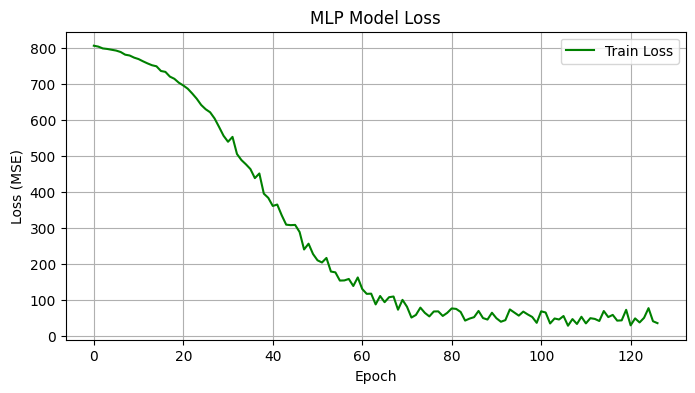

In [66]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history_mlp.history['loss'], label='Train Loss', c='g')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 4.5 Recurrent Neural Network (RNN)

In [68]:
from tensorflow.keras.layers import SimpleRNN

# Define the RNN model
rnn = Sequential([
    SimpleRNN(64, input_shape=(25, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(6, activation='linear')  # 6 outputs: currency weights
])

In [69]:
# Compile the model
rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
Total params: 6502 (25.40 KB)
Trainable params: 6502 (25.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# Visualizing Model Architecture
# from tensorflow.keras.utils import plot_model
# plot_model(rnn, to_file="rnn_model.png", show_shapes=True)

In [71]:
# Implementing early stopping as a regularization technique
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# Train the model
history_rnn = rnn.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=4,
    callbacks=[early_stopping]
)

Epoch 1/200
6/6 [==============================] - 2s 14ms/step - loss: 817.9252
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 807.7523
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 800.8600
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 788.6359
Epoch 5/200
6/6 [==============================] - 0s 10ms/step - loss: 762.5615
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 727.8586
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 667.5948
Epoch 8/200
6/6 [==============================] - 0s 10ms/step - loss: 615.9561
Epoch 9/200
6/6 [==============================] - 0s 11ms/step - loss: 578.1525
Epoch 10/200
6/6 [==============================] - 0s 12ms/step - loss: 546.1865
Epoch 11/200
6/6 [==============================] - 0s 10ms/step - loss: 507.2745
Epoch 12/200
6/6 [==============================] - 0s 9ms/step - loss: 468.3753
Epoch 13/200
6/6 [===========

In [72]:
# Make predictions
y_pred_rnn = rnn.predict(X_test_scaled)

# Normalize to sum to 100
y_pred_rnn = (y_pred_rnn / np.sum(y_pred_rnn, axis=1, keepdims=True)) * 100

1/1 [==============================] - 0s 176ms/step


In [73]:
print(np.sum(y_pred_rnn, axis=1))  # Checking if output ratios add up to 100 as in original y set

[100. 100.]


In [74]:
# Print predictions
print(y_pred_rnn)

[[24.14699    1.8404167 61.985153   4.8396435  1.9930825  5.1947184]
 [24.145924   1.8401302 61.985577   4.8401446  1.993435   5.194788 ]]


In [75]:
# Print ground truth data
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


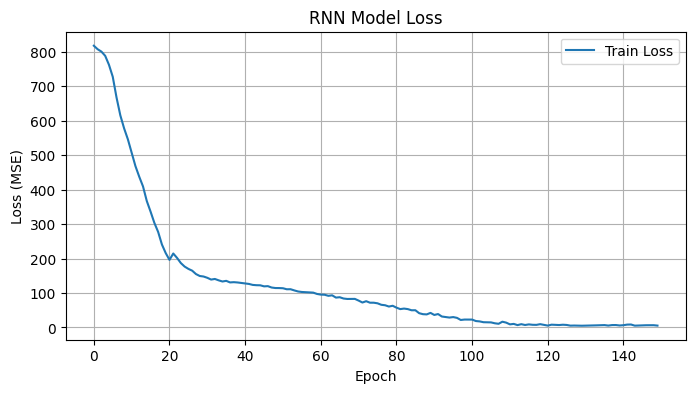

In [76]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

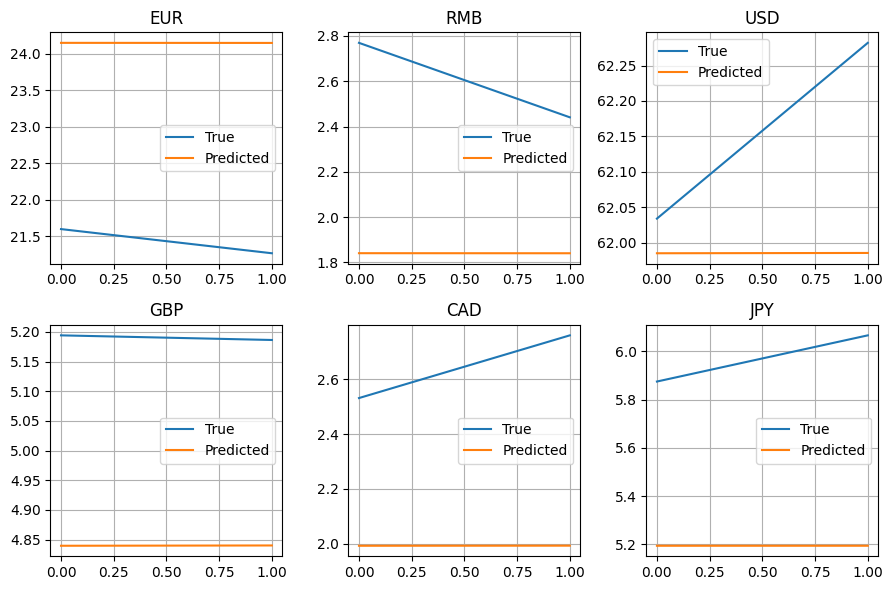

In [77]:
# Currency values comparison (USD, EUR, и т.д.)
currencies = y_test.columns
plt.figure(figsize=(9, 6))
for i, currency in enumerate(currencies):
    plt.subplot(2, 3, i+1)
    plt.plot(y_test[currency].values, label='True')
    plt.plot(y_pred_rnn[:, i], label='Predicted')
    plt.title(currency)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

## 4.6 Long Short-Term Memory (LSTM)

In [78]:
from tensorflow.keras.layers import LSTM

# Define LSTM model
lstm = Sequential([
    LSTM(64, input_shape=(25, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(6, activation='linear')  # 6 outputs: currency weights
])

In [79]:
# Compile the model
lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 19174 (74.90 KB)
Trainable params: 19174 (74.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
# Implementing early stopping as a regularization technique
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# Train
history_lstm = lstm.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=4,
    callbacks=[early_stopping]
)

Epoch 1/200
6/6 [==============================] - 3s 11ms/step - loss: 811.8462
Epoch 2/200
6/6 [==============================] - 0s 11ms/step - loss: 809.3653
Epoch 3/200
6/6 [==============================] - 0s 15ms/step - loss: 806.7708
Epoch 4/200
6/6 [==============================] - 0s 14ms/step - loss: 801.4771
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 782.5480
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 714.4261
Epoch 7/200
6/6 [==============================] - 0s 10ms/step - loss: 631.1777
Epoch 8/200
6/6 [==============================] - 0s 11ms/step - loss: 561.9303
Epoch 9/200
6/6 [==============================] - 0s 10ms/step - loss: 489.0717
Epoch 10/200
6/6 [==============================] - 0s 13ms/step - loss: 439.2419
Epoch 11/200
6/6 [==============================] - 0s 10ms/step - loss: 372.5962
Epoch 12/200
6/6 [==============================] - 0s 12ms/step - loss: 310.0190
Epoch 13/200
6/6 [=======

In [81]:
# Make predictions
y_pred_lstm = lstm.predict(X_test_scaled)

# Normalize predictions to sum to 100
y_pred_lstm = np.array([pred / np.sum(pred) * 100 for pred in y_pred_lstm])

1/1 [==============================] - 1s 501ms/step


In [82]:
print(np.sum(y_pred_lstm, axis=1))  # Checking if output ratios add up to 100 as in original y set

[ 99.99999 100.     ]


In [83]:
# Print predictions
print(y_pred_lstm)

[[22.719507   1.6097324 65.12489    4.0944986  1.7922361  4.659127 ]
 [22.717947   1.6196793 65.12228    4.0865426  1.796614   4.656944 ]]


In [84]:
# Print ground truth data
print(y_test)

          EUR       RMB        USD       GBP       CAD       JPY
23  21.595893  2.769549  62.034031  5.194131  2.531305  5.875091
24  21.264843  2.440609  62.281976  5.186331  2.759800  6.066440


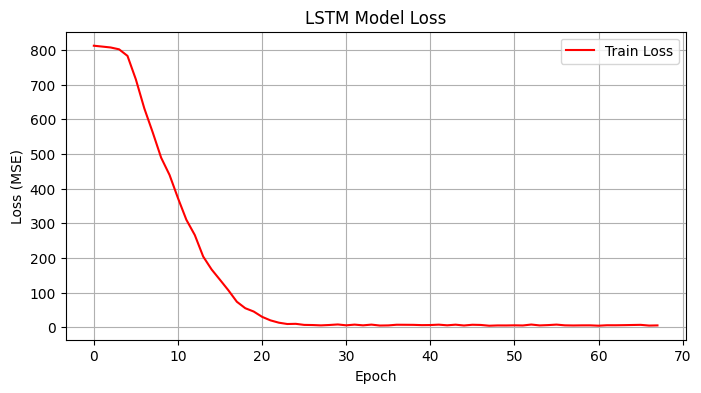

In [85]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Train Loss', c='r')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

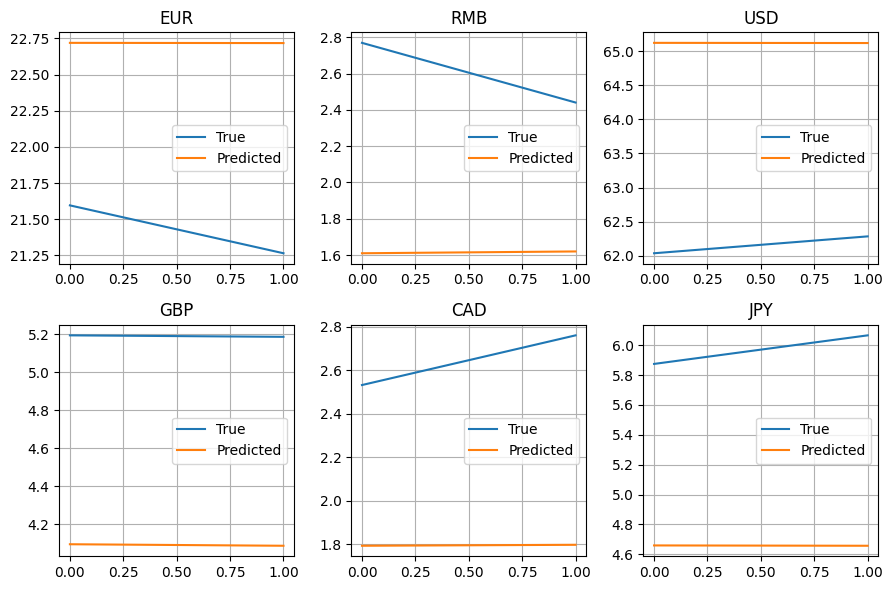

In [86]:
# Currency values comparison (USD, EUR, и т.д.)
currencies = y_test.columns
plt.figure(figsize=(9, 6))
for i, currency in enumerate(currencies):
    plt.subplot(2, 3, i+1)
    plt.plot(y_test[currency].values, label='True')
    plt.plot(y_pred_lstm[:, i], label='Predicted')
    plt.title(currency)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Metrics

- Kullback-Leibler Divergence: Lower is better
- Jensen-Shannon Divergence: Closer to 0 - better
- Cosine Similarity: Closer to 1 - better

In [87]:
# Computer metrics
from sklearn.metrics import mean_squared_error

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true, dtype=float).flatten().copy()
    y_pred = np.array(y_pred, dtype=float).flatten()

    # Normalize
    y_true /= y_true.sum()
    y_pred /= y_pred.sum()

    return {
        "cosine_similarity": cosine_similarity(y_true.reshape(1, -1), y_pred.reshape(1, -1))[0][0],
        "kl_div": sum(rel_entr(y_true, y_pred)),
        "js_div": jensenshannon(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred)
    }


In [88]:
metrics = {
    "Linear Regression": compute_metrics(y_test, y_pred_linreg),
    "Random Forest Regressor": compute_metrics(y_test, y_pred_rfr),
    "Gradient Boosting Regressor": compute_metrics(y_test, y_pred_gbr),
    "Multi-Layer Perceptron": compute_metrics(y_test, y_pred_mlp),
    "Recurrent Neural Network": compute_metrics(y_test, y_pred_rnn),
    "Long Short-Term Memory": compute_metrics(y_test, y_pred_lstm),
}

In [89]:
model_metrics = pd.DataFrame(metrics).T  # Transpose to get models as rows
print(model_metrics)

                             cosine_similarity    kl_div    js_div       mse
Linear Regression                     0.931145  0.091579  0.151324  0.002453
Random Forest Regressor               0.998963  0.008885  0.045668  0.000102
Gradient Boosting Regressor           0.999157  0.004198  0.032007  0.000070
Multi-Layer Perceptron                0.997300  0.039531  0.088434  0.000140
Recurrent Neural Network              0.999005  0.004732  0.033934  0.000038
Long Short-Term Memory                0.999304  0.008527  0.044900  0.000063


# 6. Exporting the model

In [90]:
import joblib

joblib.dump(lin_reg, "linreg_model.pkl")
joblib.dump(rfr, "rfr_model.pkl")
joblib.dump(multi_output_gbr, "gbr_model.pkl")

print("Models successfully exported to /content/models")

Models successfully exported to /content/models


In [91]:
# Export the Keras model to TensorFlow.js format
import tensorflowjs as tfjs

In [92]:
# @title
# Save Multi-Layer Perceptron
tfjs.converters.save_keras_model(mlp, "/content/models/mlp")

# Save Recurrent Neural Network
tfjs.converters.save_keras_model(rnn, "/content/models/rnn")

# Save LSTM
tfjs.converters.save_keras_model(lstm, "/content/models/lstm")

print("Models successfully exported to /content/models")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models successfully exported to /content/models
